In [2]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import os
from scipy import stats
import numpy as np
from os import listdir
import string
import matplotlib.pyplot as plt

### Preparation: Calculate the forward returns for stocks and market indices

In [3]:
csv_path = "Data/"
stockclose = "StockClosePrice"
indexclose = "IndexClosePrice"

forward_day = 5 # this should depend on the rolling period

# calculate the forward returns
stock = pd.read_csv(csv_path + stockclose + ".csv", index_col = 0, parse_dates = True)
stockforward = stock.shift(periods = -forward_day, freq = None, axis = 0)
# 5Dforward(t) = (close_price(t+5)-close_price(t))/close_price(t)
stockforwardreturn = (stockforward - stock) / stock
print(stockforwardreturn.head())
stockforwardreturn.to_csv(os.path.join(csv_path, '5DForward.csv')) #stock

# The indices returns are calculated as well
index = pd.read_csv(csv_path + indexclose + ".csv", index_col = 0, parse_dates = True)
indexforward = index.shift(periods = -forward_day, freq = None, axis = 0)
indexforwardreturn = (indexforward - index) / index
print(indexforwardreturn.head())
indexforwardreturn.to_csv(os.path.join(csv_path, 'mkt_5DForward.csv')) #mkt

            000001.SZ  000002.SZ  000004.SZ  000005.SZ  000006.SZ  000007.SZ  \
date                                                                           
2007-01-04   0.047482   0.061368   0.088638   0.186231   0.065688   0.122858   
2007-01-05   0.188363   0.084177   0.094316   0.107551  -0.016348   0.037043   
2007-01-08   0.219149   0.158273   0.103618   0.111985   0.006898   0.031495   
2007-01-09   0.233333   0.230769   0.096691   0.135329   0.075422   0.031128   
2007-01-10   0.208806   0.006994   0.083142   0.096759  -0.043272   0.007674   

            000008.SZ  000009.SZ  000010.SZ  000011.SZ  ...  603987.SH  \
date                                                    ...              
2007-01-04   0.250000   0.125307        0.0   0.128390  ...        NaN   
2007-01-05   0.122891   0.073622        0.0   0.079454  ...        NaN   
2007-01-08   0.140277   0.086213        0.0   0.092567  ...        NaN   
2007-01-09   0.130120   0.044423        0.0   0.123708  ...        Na

### Read the factors

In [3]:
factor_folder = "Data/ALL_factors/"
factor_list = set(os.listdir(factor_folder)) - set(['.DS_Store'])
factor_list = list(factor_list)

# Read all factor files
# Z-score the factor values to remove the scale differences
dfs = []
i = 0
for factor in factor_list:
    dfs.append(factor)
    df = pd.read_csv(factor_folder + factor , index_col = 0, parse_dates = True)
    dfs[i] = (df - df.mean()) / df.std() 
    i = i + 1

print(dfs[0].head())

            000001.SZ  000002.SZ  000004.SZ  000005.SZ  000006.SZ  000007.SZ  \
date                                                                           
2008-01-02   0.856878   0.191145   0.410847  -0.494175   0.510315  -0.207984   
2008-01-03   0.869264   0.235714   0.347028  -0.522589   0.469161  -0.209420   
2008-01-04   0.610174   0.230717   0.308799  -0.532473   0.467704  -0.235161   
2008-01-07   0.616198  -0.018342   0.247824  -0.559446   0.475717  -0.217816   
2008-01-08   0.521690  -0.038128   0.238030  -0.556049   0.484821  -0.230963   

            000008.SZ  000009.SZ  000010.SZ  000011.SZ  ...  603987.SH  \
date                                                    ...              
2008-01-02  -0.248588  -0.270660  -0.219987  -0.280379  ...        NaN   
2008-01-03  -0.256872  -0.280071  -0.219987  -0.312504  ...        NaN   
2008-01-04  -0.240184  -0.236388  -0.219987  -0.282842  ...        NaN   
2008-01-07  -0.202124  -0.236033  -0.219987  -0.309720  ...        Na

## Use Machine Learning Models to construct new factors.

Supervised learning methods with inputs being factor values, targets being stock returns are applied. 

### Data Transformation

### Clean Return Data

In [4]:
# clean return data
import datetime
# rows cleaning
st = datetime.datetime(2008, 1, 2, 0, 0)
en = datetime.datetime(2018, 7, 5, 0, 0)
rt =stockforwardreturn[st:en]


a = dfs[0].columns.tolist()
b = rt.columns.tolist()
more = list(set(b) - set(a))
rt = rt.drop(more,axis=1)

In [5]:
print(rt.shape)
print(dfs[0].shape)

(2557, 3569)
(2557, 3569)


### Melt DataFrames as One

In [6]:
for i in range(len(dfs)):
    dfs[i] = dfs[i].reset_index()
    dfs[i] = pd.melt(frame=dfs[i],id_vars='date',value_vars=dfs[i].columns.tolist()[1:],var_name='stock',value_name=factor_list[i].rstrip('.csv'))

In [7]:
melted = pd.DataFrame()
melted = pd.concat([melted,dfs[0]],axis=1)

In [8]:
for i in range(1,len(dfs)):
    melted = pd.merge(left=melted,right=dfs[i],on=['date','stock'])

In [9]:
rt = rt.reset_index()
rt = pd.melt(frame=rt ,id_vars='date', value_vars=rt.columns.tolist()[1:],var_name='stock',value_name='return')

In [10]:
melted = pd.merge(left=melted,right=rt,on=['date','stock'])

In [11]:
melted.head()

,date,stock,GainLossVarianceRatio60,ROAEBITTTM,VEMA10,GainLossVarianceRatio20,DAVOL20,InformationRatio60,TVMA6,LongTermDebtToAsset,...,TVMA20,PEIndu,GREV,PSIndu,GainLossVarianceRatio120,AD,RealizedVolatility,GainVariance120,PEHist120,return
0,2008-01-02,000001.SZ,0.856878,NaN,-0.717872,0.130487,-0.158321,0.111823,-0.001905,NaN,...,-0.073158,-0.366891,1.047256,0.561348,0.616604,-0.992037,NaN,1.754985,-0.056532,0.082412
1,2008-01-03,000001.SZ,0.869264,NaN,-0.703739,0.141101,-0.206822,-0.242802,0.022230,NaN,...,-0.089092,-0.372034,0.996887,0.577248,0.636665,-0.991141,NaN,1.754985,-0.087318,0.123159
2,2008-01-04,000001.SZ,0.610174,NaN,-0.716201,0.143305,-0.255323,0.023636,0.032540,NaN,...,-0.097660,-0.364962,0.946518,0.561544,0.614573,-0.986487,NaN,1.728368,-0.039740,0.148814
3,2008-01-07,000001.SZ,0.616198,NaN,-0.690041,0.133320,-0.134070,0.232845,0.149184,NaN,...,-0.061294,-0.356511,0.896149,0.564489,0.596417,-0.981773,NaN,1.703526,-0.002984,0.109267
4,2008-01-08,000001.SZ,0.521690,NaN,-0.610939,-0.150077,0.059935,0.391395,0.268527,NaN,...,0.034590,-0.339611,0.845781,0.589418,0.574071,-0.981442,NaN,1.675135,0.053177,0.040604


In [12]:
melted.shape

(9125933, 47)

In [13]:
na = melted.dropna()

In [14]:
na.shape

(1850785, 47)

In [15]:
#to normalize return
from sklearn import preprocessing
na['return'] = preprocessing.scale(na['return'])
na.head()

,date,stock,GainLossVarianceRatio60,ROAEBITTTM,VEMA10,GainLossVarianceRatio20,DAVOL20,InformationRatio60,TVMA6,LongTermDebtToAsset,...,TVMA20,PEIndu,GREV,PSIndu,GainLossVarianceRatio120,AD,RealizedVolatility,GainVariance120,PEHist120,return
2877,2009-04-27,000002.SZ,-0.996424,-0.113236,0.661992,0.246423,0.129583,-0.603765,-0.104723,0.943263,...,0.197462,-0.006018,-1.202228,-0.103165,-0.953023,-1.010245,-0.122382,0.559304,1.364283,1.893689
2878,2009-04-28,000002.SZ,-1.009071,-0.113236,0.464868,0.204103,0.054783,-0.585792,-0.240881,0.943263,...,0.162323,-0.213253,-1.202228,-0.377176,-0.957195,-1.006186,-0.125375,0.559304,1.323707,2.160503
2879,2009-04-29,000002.SZ,-1.028347,-0.113236,0.456447,0.230002,0.054783,-0.413546,-0.268465,0.943263,...,0.165662,-0.166943,-1.202228,-0.403694,-1.009496,-0.982256,-0.281026,0.461512,1.530835,1.427726
2880,2009-04-30,000002.SZ,-1.029264,-0.113236,0.655048,0.141412,0.110883,-0.182139,-0.269660,0.943263,...,0.195972,-0.109057,-1.202228,-0.378650,-1.009943,-0.995862,-0.176261,0.461512,1.632275,2.347278
2881,2009-05-04,000002.SZ,-1.104023,-0.113236,0.999093,-0.185426,0.092183,-0.132712,-0.048233,0.943263,...,0.208348,0.024083,-1.202228,-0.431684,-1.015456,-0.929487,-0.218167,0.450007,1.829023,1.649318


### Train-Test Split

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X=na.drop(['return','date','stock'],axis=1)
y=na.filter(['return'])

In [18]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=233)

In [19]:
X_train.head()

,GainLossVarianceRatio60,ROAEBITTTM,VEMA10,GainLossVarianceRatio20,DAVOL20,InformationRatio60,TVMA6,LongTermDebtToAsset,ATR14,SalesExpenseTTM,...,Price1Y,TVMA20,PEIndu,GREV,PSIndu,GainLossVarianceRatio120,AD,RealizedVolatility,GainVariance120,PEHist120
1505660,1.315050,-0.118240,0.179406,1.675501,-0.662310,0.778278,-0.065422,-0.490560,-0.665303,0.803047,...,0.537736,-0.152824,0.173203,-0.107708,0.487469,-0.387267,-1.178199,-0.748071,1.114344,-0.043659
1171801,-0.508122,-0.468654,0.707506,-0.276558,1.379419,0.082754,1.152403,-0.411818,1.030851,-1.652076,...,1.493468,0.387712,0.217651,-1.011716,1.855123,-0.216691,-0.554253,-0.015382,-0.061526,0.028114
1115312,-0.040209,-0.297490,0.561660,0.935836,-0.021466,0.309288,0.571898,-0.004054,0.104712,-1.830387,...,1.832429,0.820369,1.049878,0.938821,2.353244,-1.006641,0.375281,-0.045630,-0.092232,0.046810
1062637,0.874685,1.887528,-0.177923,-0.548720,-0.040229,0.853528,-0.018474,0.350603,0.944060,0.282848,...,0.729593,-0.101303,-0.528850,1.418338,0.373962,-0.201737,-0.298271,0.676585,-0.231740,-0.020444
1354344,3.231000,-0.497913,2.884196,1.813840,2.182484,0.244968,2.881935,-0.341514,2.306522,0.948322,...,1.832750,2.184009,0.517730,0.052950,1.877514,1.848547,0.791503,-0.758018,0.433109,2.018766


In [20]:
X_train.shape

(1388088, 44)

### Lasso

Given the fact that 44 predictors are given to us, we apply a lasso regression with cross-validation. The LASSO (Least Absolute Shrinkage and Selection Operator) is a method of automatic variable selection which can be used to select predictors X* of a target variable Y from a larger set of potential or candidate predictors X.

In [59]:
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error

### Lasso with different alphas

In [60]:
alphas = 10**np.linspace(6,-2,50)*0.5
alphas

array([5.00000000e+05, 3.43324423e+05, 2.35743318e+05, 1.61872877e+05,
       1.11149824e+05, 7.63208984e+04, 5.24056567e+04, 3.59842837e+04,
       2.47085668e+04, 1.69661089e+04, 1.16497591e+04, 7.99929360e+03,
       5.49270571e+03, 3.77156003e+03, 2.58973734e+03, 1.77824015e+03,
       1.22102655e+03, 8.38416468e+02, 5.75697700e+02, 3.95302161e+02,
       2.71433772e+02, 1.86379686e+02, 1.27977396e+02, 8.78755312e+01,
       6.03396320e+01, 4.14321386e+01, 2.84493301e+01, 1.95346997e+01,
       1.34134790e+01, 9.21034985e+00, 6.32427608e+00, 4.34255687e+00,
       2.98181166e+00, 2.04745753e+00, 1.40588435e+00, 9.65348864e-01,
       6.62855683e-01, 4.55149089e-01, 3.12527596e-01, 2.14596713e-01,
       1.47352585e-01, 1.01179482e-01, 6.94747747e-02, 4.77047738e-02,
       3.27564278e-02, 2.24921633e-02, 1.54442180e-02, 1.06047544e-02,
       7.28174239e-03, 5.00000000e-03])

In [61]:
lasso = Lasso()
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    
np.shape(coefs)

(50, 44)

### Cross Validation Lasso

We now split the samples into a training set and a test set in order to estimate the test error. We perform 10-fold cross-validation to choose the best alpha, refit the mode, compute the associated test error and print the best models coefficients .

In [63]:
# Use the cross-validation package to split data into training and test sets
lassocv = LassoCV(alphas=None, cv=10)
lassocv.fit(X_train, y_train)
lasso.set_params(alpha=lassocv.alpha_)
print("Alpha=", lassocv.alpha_)
lasso.fit(X_train, y_train)
print("mse = ",mean_squared_error(y_test, lasso.predict(X_test)))
print("best model coefficients:")
pd.Series(lasso.coef_, index=X.columns)


Alpha= 9.866027337456427e-05
mse =  0.9828775687083147
best model coefficients:


GainLossVarianceRatio60     0.016325
ROAEBITTTM                  0.000000
VEMA10                      0.079680
GainLossVarianceRatio20    -0.014839
DAVOL20                    -0.025474
InformationRatio60         -0.002250
TVMA6                      -0.038093
LongTermDebtToAsset         0.002127
ATR14                       0.000000
SalesExpenseTTM             0.007112
PEHist250                   0.005278
SUE                         0.000658
REVS750                    -0.025875
SaleServiceRenderCashTTM   -0.006700
STOM                        0.061771
GainVariance20              0.046682
InformationRatio120        -0.060970
SBM                         0.014235
PE                         -0.022507
PBIndu                      0.004439
NonOperatingNPTTM           0.010024
SalesCostRatio             -0.011325
DAREV                       0.014401
MoneyFlow20                -0.118726
MktValue                    0.006169
InterestCover              -0.006781
ROE5                       -0.003432
I

In [64]:
print("mse lasso = ", mean_squared_error(y_test, lasso.predict(X_test)))

mse lasso =  0.9828775687083147


In [66]:
# We comment the following code for the synsetic factor has already been written to a CSV file
'''
save_results_path = 'Data/Lasso/'
results=lasso.predict(X)
results=pd.DataFrame(results)
na.insert(loc=0,column='predictedy',value=results.values)
for_bt=pd.merge(melted,na,how='left',on=['date','stock'])
for_bt=for_bt[['date','stock','predictedy']]
#formatting
td_bt=pd.Series(list(for_bt['predictedy']),index=[for_bt['date'],for_bt['stock']])
td_bt=td_bt.unstack()
print(td_bt.shape)
td_bt.to_csv(os.path.join(save_results_path, 'lasso.csv'))
'''

"\nsave_results_path = 'Data/Lasso/Original'\nresults=lasso.predict(X)\nresults=pd.DataFrame(results)\nna.insert(loc=0,column='predictedy',value=results.values)\nfor_bt=pd.merge(melted,na,how='left',on=['date','stock'])\nfor_bt=for_bt[['date','stock','predictedy']]\n#formatting\ntd_bt=pd.Series(list(for_bt['predictedy']),index=[for_bt['date'],for_bt['stock']])\ntd_bt=td_bt.unstack()\nprint(td_bt.shape)\ntd_bt.to_csv(os.path.join(save_results_path, 'lasso.csv'))\n"

# Back Test Simulation

In [71]:
# helper.py has all formulas and plotting functions with the vanilla setting 
%run -i 'helper.py'
#helperTC.py has all formulas and plotting functions considering Transaction Cost
%run -i 'helper_tc.py'
# backtestlite.py has all formulas for a backtest with the vanilla setting 
%run -i 'backtestlite.py'
# backtestlite.py has all formulas for a backtest considering assignment of different weights
%run -i 'backtestlite_weight.py'
# backtestlite.py has all formulas for a backtest considering Transaction Cost
%run -i 'backtestlite_tc.py'

Through trial and error, we found that the synthetic factor from Lasso Regression has a positive relationship with the 5-day forward return

Hence, an Ascending direction is assigned to the back-test model.

In [60]:
#set the working directory and some initial parameters. 
working_directory = 'Data/'
#Directory to import the factor you built
factor_path_all = 'Data/Lasso/'

# Define the factor direction, (Descending or Ascending).
direction = "Ascending" 
###############################################################

# Parameters of backtest.
start = '20110101' # Time horizon, can be vacation, progrmme will extract the maximum subset.
end = '20180601'
quantile = 5
cycle = 5 # Adjustment Cycle (trading frequency), delay for holidays. 
win = 48 # 48 weeks in a year
year = 2011 # Beginning year of result display (graphs).

#Import stock 5days forward return.
fwdrtn = pd.read_csv(os.path.join(working_directory, "5DForward.csv"), index_col = 0, parse_dates = True).loc[start:end][::cycle]
#Import market 5days forward return.
mkt_index = pd.read_csv(os.path.join(working_directory, "mkt_5DForward.csv"), index_col = 0, parse_dates = True).loc[str(start):str(end),"SH000905"][::cycle]

# Revise the factor name (name of .csv file)
factor = "lasso"

#with no status limits
status = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)
statuslimit = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)


# Original Back-Test

This back test follows the sample code given.

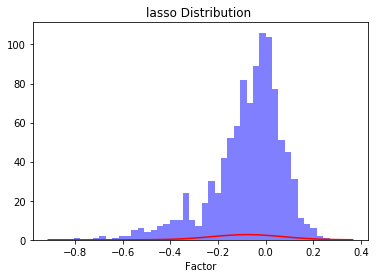

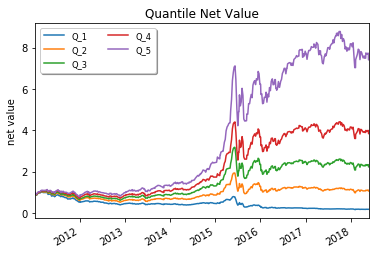

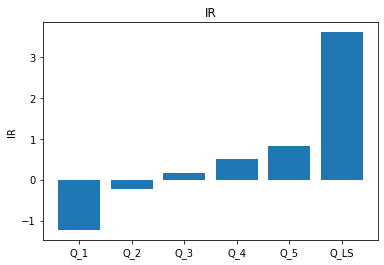

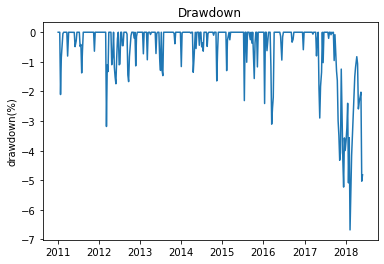

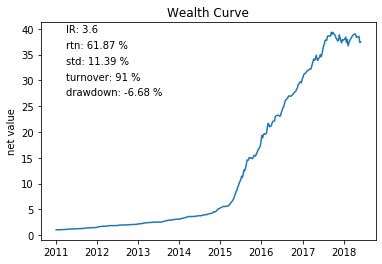

In [58]:
#A new argument used to store the output from the backtest
save_output_path = 'Data/Lasso/Original'

Type = "LS" # this stand for long-short strategy. 

def singlefactor(factor,factor_path_all,save_output_path, Type,direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit):
    factor_path = os.path.join(factor_path_all, factor + '.csv')
     
    Type1 = "LS"
    B = Backtestlite(factor_path, direction, fwdrtn, mkt_index, save_output_path, cycle, start, end, quantile, statuslimit)
    B.run(Type1)

    # Drawing
    pic = DrawPicture(factor,direction, B.data,  B.fwdrtn, B.data.index , mkt_index,  B.rtn_data, B.coverage, B.turnover, save_output_path, Type1)    
    pic.main(win,year,B.rtn_data.columns)
    
# Calculate performances and do the plot
singlefactor(factor,factor_path_all, save_output_path, Type, direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit)

# More Considerations

## Shorting Constraints

Shorting single stocks in China is usually not allowed. instead, quantitative fund managers short stock index futures such as CSI 500. Hence, we change the shorting from single stocks to CSI 500.

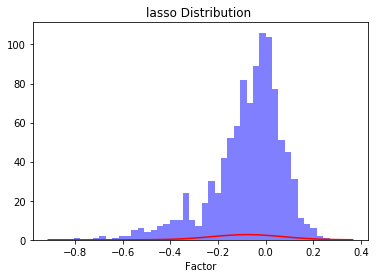

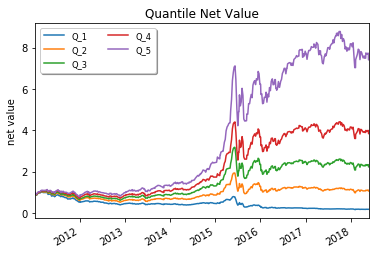

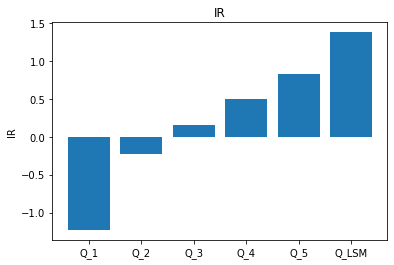

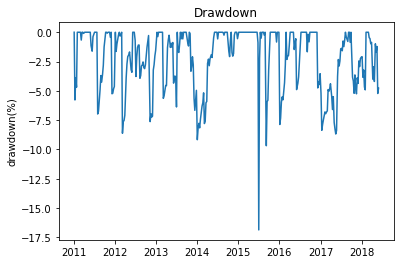

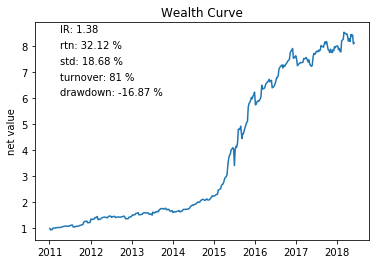

In [6]:
#A new argument used to store the output from the backtest
save_output_path = 'Data/Lasso/LSM'

Type = "LSM" 

def singlefactor(factor,factor_path_all,save_output_path, Type,direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit):
    factor_path = os.path.join(factor_path_all, factor + '.csv')

    Type1 = "LSM"
    B = Backtestlite(factor_path, direction, fwdrtn, mkt_index, save_output_path, cycle, start, end, quantile, statuslimit)
    B.run(Type1)

    # Drawing
    pic = DrawPicture(factor,direction, B.data,  B.fwdrtn, B.data.index , mkt_index,  B.rtn_data, B.coverage, B.turnover,save_output_path, Type1)    
    pic.main(win,year,B.rtn_data.columns)
    
# Calculate performances and do the plot
singlefactor(factor,factor_path_all,save_output_path, Type, direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit)

### Comparable Analysis
After adding the shorting constraints, the information ratio drops from 3.6 to 1.38, and the maximum drawdown expanded from 6.68% to 16.87%. This drives down the risk-adjusted retun and increases the downside risk.

##  Differentiated Weights

Instead of assigning equal weight to the selected stock in each tranche. We split the stock within each tranche into 2 parts, and the first half percentile of in-tranche stocks have a weight 3 times larger than that in the other half.

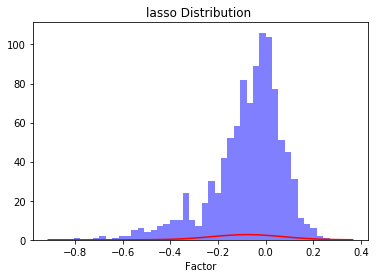

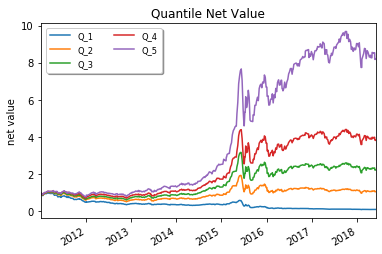

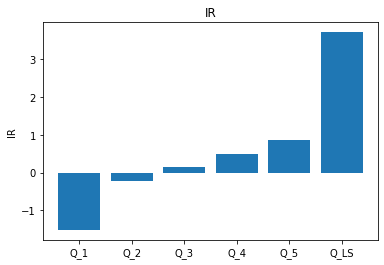

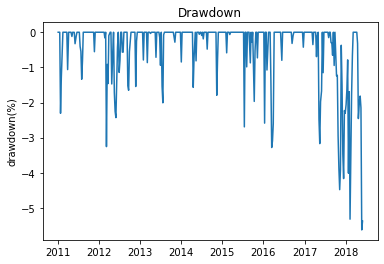

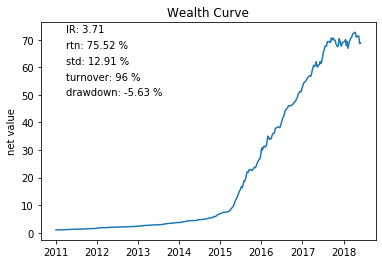

In [63]:
#A new argument used to store the output from the backtest
save_output_path = 'Data/Lasso/Weighting'

Type = "LS" # this stand for long-short strategy. 
# Don't change this unless you are confident with the codes in backtestlite.py

def singlefactor(factor,factor_path_all,save_output_path, Type,direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit):
    factor_path = os.path.join(factor_path_all, factor + '.csv')

    Type1 = "LS"
    B = Backtestlite_weight(factor_path, direction, fwdrtn, mkt_index, save_output_path, cycle, start, end, quantile, statuslimit)
    B.run(Type1)

    # Drawing
    pic = DrawPicture(factor,direction, B.data,  B.fwdrtn, B.data.index , mkt_index,  B.rtn_data, B.coverage, B.turnover, save_output_path, Type1)    
    pic.main(win,year,B.rtn_data.columns)
    
# Calculate performances and do the plot
singlefactor(factor,factor_path_all, save_output_path, Type, direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit)

### Comparable Analysis
After adding more weight to the better-performed stocks, the information ratio increased from 3.6 to 3.71, and the maximum drawdown shrinked from 6.68% to 5.63%. This makes perfect sense for we long more stock with better performance, and short more stock with worse perforance. Thus, the risk-adjusted return has been improved and the maximum drawdown has been mitigated.

# Trading Feasibility

In most cases, when the stock reaches its limit (+10% or -10%) right after the opening, there is little chance to make moves, i.e., to sell a bad stock or to buy a good stock.

In [64]:
#Import the opening price to calculate the daily movement of each stock
csv_path = "Data/"
stockclose = "StockClosePrice"
stockopen = "StockOpenPrice"

stockClose = pd.read_csv(csv_path + stockclose + ".csv", index_col = 0, parse_dates = True).shift(1, axis = 0)
stockOpen = pd.read_csv(csv_path + stockopen + ".csv", index_col = 0, parse_dates = True)

In [65]:
stockClose.head()

,000001.SZ,000002.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,...,603987.SH,603988.SH,603989.SH,603990.SH,603991.SH,603993.SH,603996.SH,603997.SH,603998.SH,603999.SH
date,,,,,,,,,,,,,,,,,,,,,
2007-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-05,411.504,469.123,23.094,25.216,133.830,19.087,12.708,13.838,14.461,12.096,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-08,380.881,450.030,22.923,25.625,137.444,19.653,12.922,13.773,14.461,12.007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-09,389.922,463.365,23.606,26.441,141.644,20.543,13.288,14.035,14.461,12.229,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-10,402.463,472.759,24.118,27.156,145.063,20.785,13.380,14.722,14.461,12.384,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
stockOpen.head()

,000001.SZ,000002.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,...,603987.SH,603988.SH,603989.SH,603990.SH,603991.SH,603993.SH,603996.SH,603997.SH,603998.SH,603999.SH
date,,,,,,,,,,,,,,,,,,,,,
2007-01-04,427.252,475.790,23.435,25.625,131.876,19.734,12.708,0.000,0.0,12.828,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-05,406.254,463.668,22.809,25.216,134.806,19.087,12.891,13.838,0.0,12.007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-08,380.590,447.909,23.037,25.522,136.858,19.653,12.922,13.773,0.0,11.763,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-09,390.505,464.274,23.549,26.543,140.472,20.543,13.288,14.133,0.0,12.229,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-10,402.171,478.820,23.890,27.156,143.891,20.785,13.349,15.081,0.0,12.429,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
limit = (stockOpen - stockClose) / stockClose
limit.head()

,000001.SZ,000002.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,...,603987.SH,603988.SH,603989.SH,603990.SH,603991.SH,603993.SH,603996.SH,603997.SH,603998.SH,603999.SH
date,,,,,,,,,,,,,,,,,,,,,
2007-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-05,-0.012758,-0.011628,-0.012341,0.000000,0.007293,0.0,0.014400,0.000000,-1.0,-0.007358,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-08,-0.000764,-0.004713,0.004973,-0.004020,-0.004264,0.0,0.000000,0.000000,-1.0,-0.020321,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-09,0.001495,0.001962,-0.002415,0.003858,-0.008274,0.0,0.000000,0.006983,-1.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-10,-0.000726,0.012820,-0.009454,0.000000,-0.008079,0.0,-0.002317,0.024385,-1.0,0.003634,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


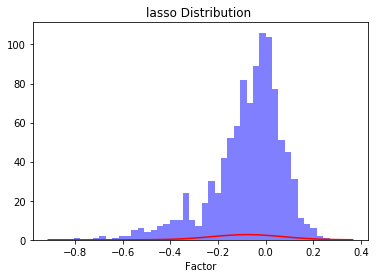

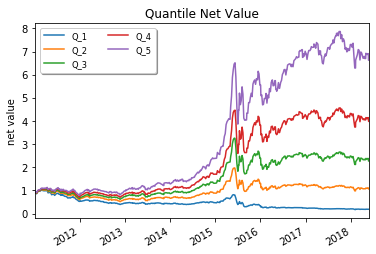

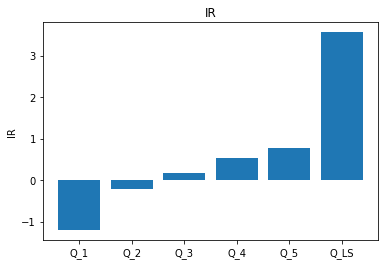

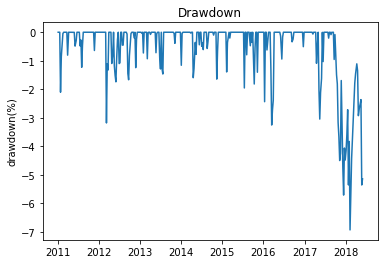

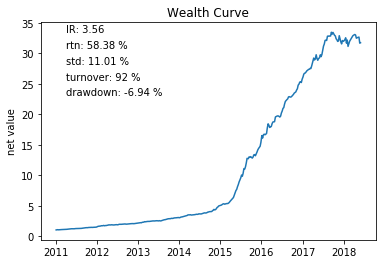

In [68]:
#set the trading constraints
limit =limit[start:end]
status = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)
statuslimit = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)
statuslimit[limit.abs()>0.1]=0

#A new argument used to store the output from the backtest
save_output_path = 'Data/Lasso/Limit'

Type = "LS" # this stand for long-short strategy. 

def singlefactor(factor,factor_path_all,save_output_path, Type,direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit):
    factor_path = os.path.join(factor_path_all, factor + '.csv')
     
    Type1 = "LS"
    B = Backtestlite(factor_path, direction, fwdrtn, mkt_index, save_output_path, cycle, start, end, quantile, statuslimit)
    B.run(Type1)

    # Drawing
    pic = DrawPicture(factor,direction, B.data,  B.fwdrtn, B.data.index , mkt_index,  B.rtn_data, B.coverage, B.turnover, save_output_path, Type1)    
    pic.main(win,year,B.rtn_data.columns)
    
# Calculate performances and do the plot
singlefactor(factor,factor_path_all, save_output_path, Type, direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit)

### Comparable Analysis
After adding the shorting constraints, the information ratio drops slightly from 3.6 to 3.56, and the maximum drawdown rose from 6.68% to 6.94%. Hence, the effects of Trading Feasibility is not very significant to our LS strategy under lasso synthetic factors.

# Trading Cost
Each trade, either long or short, could charge a percentage fee of trading volume.

## First, we try a transaction coat of 0.001 as suggested.

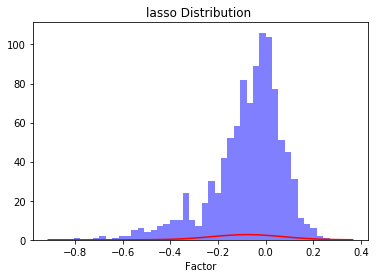

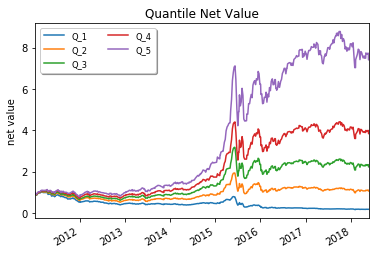

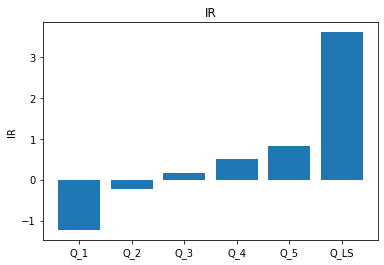

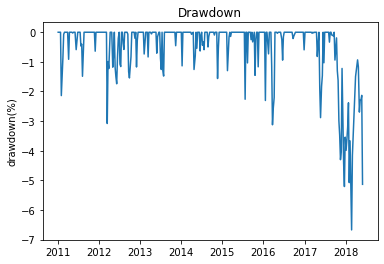

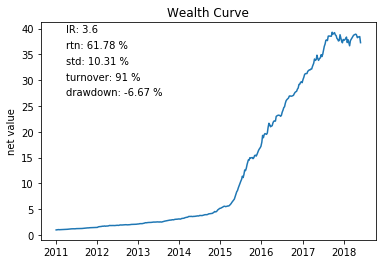

In [72]:
#initialize the status limit
status = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)
statuslimit = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)

#A new argument used to store the output from the backtest
save_output_path = 'Data/Lasso/TC'

Type = "LS" # this stand for long-short strategy. 

#transaction cost(tc)
tc = 0.001

def singlefactor(factor,factor_path_all,save_output_path, Type,direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit):
    factor_path = os.path.join(factor_path_all, factor + '.csv')
     
    Type1 = "LS"
    B = Backtestlite_tc(factor_path, direction, fwdrtn, mkt_index, save_output_path, cycle, start, end, quantile, statuslimit, tc)
    B.run(Type1)

    # Drawing
    pic = DrawPicture_tc(factor,direction, B.data,  B.fwdrtn, B.data.index , mkt_index,  B.rtn_data, B.coverage, B.turnover, save_output_path, Type1, B.net_value_tc, B.ls_rtn_tc)    
    pic.main(win,year,B.rtn_data.columns)
    
# Calculate performances and do the plot
singlefactor(factor,factor_path_all, save_output_path, Type, direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit)

### Comparable Analysis
With a turnover rate of 91%, a transaction cost of 0.001 has limited effects on our risk-adjusted performance, and maximum drawdown for our performance barely changed.

## Then, we try a transaction coat of 0.01

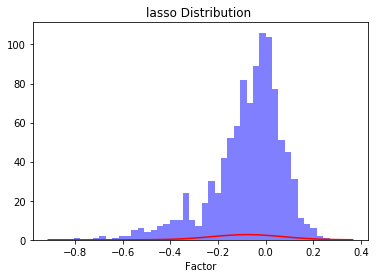

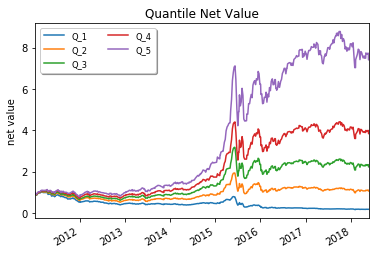

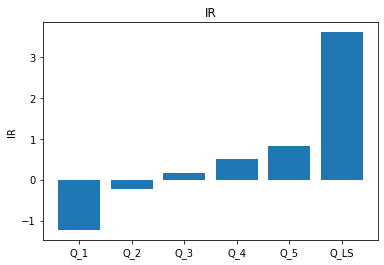

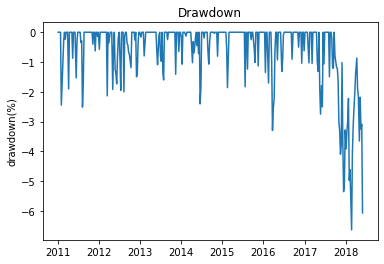

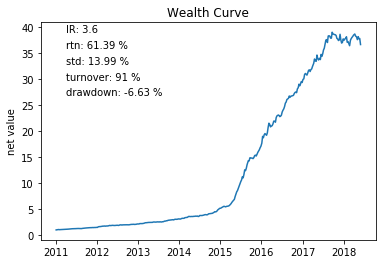

In [74]:
#initialize the status limit
status = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)
statuslimit = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)

#A new argument used to store the output from the backtest
save_output_path = 'Data/Lasso/TC'

Type = "LS" # this stand for long-short strategy. 

#transaction cost(tc)
tc = 0.01

def singlefactor(factor,factor_path_all,save_output_path, Type,direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit):
    factor_path = os.path.join(factor_path_all, factor + '.csv')
     
    Type1 = "LS"
    B = Backtestlite_tc(factor_path, direction, fwdrtn, mkt_index, save_output_path, cycle, start, end, quantile, statuslimit, tc)
    B.run(Type1)

    # Drawing
    pic = DrawPicture_tc(factor,direction, B.data,  B.fwdrtn, B.data.index , mkt_index,  B.rtn_data, B.coverage, B.turnover, save_output_path, Type1, B.net_value_tc, B.ls_rtn_tc)    
    pic.main(win,year,B.rtn_data.columns)
    
# Calculate performances and do the plot
singlefactor(factor,factor_path_all, save_output_path, Type, direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit)

### Comparable Analysis
With a turnover rate of 91%, we increase the transaction cost of from 0.001 to 0.01. Still, there is limited effect on our risk-adjusted performance. The maximum drawdown for our performance even improved slightly, for the transaction costs flattened our wealth curve .

# With  multiple constraints on Shorting constraints, Trading Feasibility, and Transaction cost

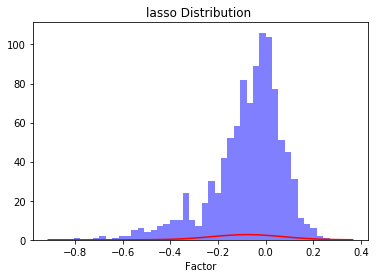

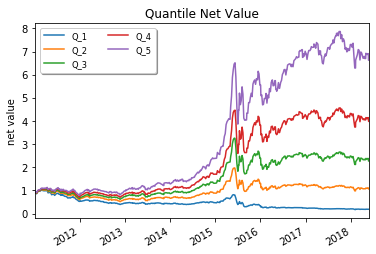

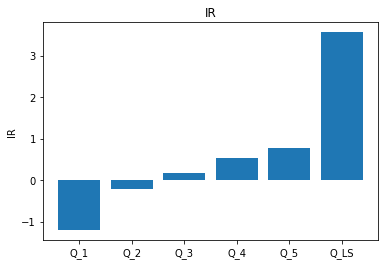

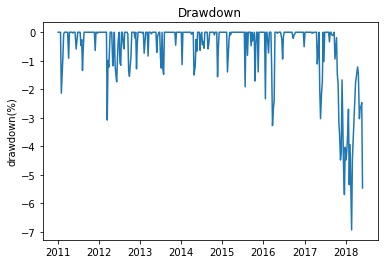

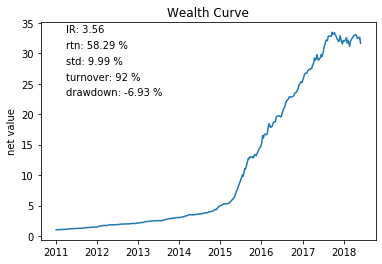

In [76]:
#A new argument used to store the output from the backtest
save_output_path = 'Data/Lasso/MultipleCons'

######## I. Shorting constraints
Type = "LSM" # this stands for long stocks and short market index 

####### II.Trading Feasibility (+10% or -10%)
#Import the opening price to calculate the daily movement of each stock
csv_path = "Data/"
stockclose = "StockClosePrice"
stockopen = "StockOpenPrice"

stockClose = pd.read_csv(csv_path + stockclose + ".csv", index_col = 0, parse_dates = True).shift(1, axis = 0)
stockOpen = pd.read_csv(csv_path + stockopen + ".csv", index_col = 0, parse_dates = True)

limit = (stockOpen - stockClose) / stockClose

#set the trading constraints
limit =limit[start:end]
status = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)
statuslimit = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)
statuslimit[limit.abs()>0.1]=0

####### III. transaction cost(tc)
tc = 0.001

def singlefactor(factor,factor_path_all,save_output_path, Type,direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit):
    factor_path = os.path.join(factor_path_all, factor + '.csv')
     
    Type1 = "LS"
    B = Backtestlite_tc(factor_path, direction, fwdrtn, mkt_index, save_output_path, cycle, start, end, quantile, statuslimit, tc)
    B.run(Type1)

    # Drawing
    pic = DrawPicture_tc(factor,direction, B.data,  B.fwdrtn, B.data.index , mkt_index,  B.rtn_data, B.coverage, B.turnover, save_output_path, Type1, B.net_value_tc, B.ls_rtn_tc)    
    pic.main(win,year,B.rtn_data.columns)
    
# Calculate performances and do the plot
singlefactor(factor,factor_path_all, save_output_path, Type, direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit)

### Comparable Analysis
With a turnover rate of 92%, a transaction cost of of 0.001, constraints on trading frequency and short position, the inforamtion ratio dropped a little to 3.56, and the maximum drawdown expanded slightly from 6.68% to 6.93%. In other words, even we after add 3 constraints on our factor-investment portfolio, we can still maintain a robust risk-adjusted performance.
